## Cosine similarity

In [1]:
import numpy as np

def cos_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    l2_norm = np.sqrt(sum(np.square(v1))) * np.sqrt(sum(np.square(v2)))
    similarity = dot_product / l2_norm
    
    return similarity

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

doc_list = ['if you take the blue pill, the story ends' ,
            'if you take the red pill, you stay in Wonderland',
            'if you take the red pill, I show you how deep the rabbit hole goes']

tfidf_vect_simple = TfidfVectorizer()
feature_vect_simple = tfidf_vect_simple.fit_transform(doc_list)

print(type(feature_vect_simple), feature_vect_simple.shape)
print(feature_vect_simple)


<class 'scipy.sparse.csr.csr_matrix'> (3, 18)
  (0, 2)	0.41556360057939173
  (0, 13)	0.41556360057939173
  (0, 8)	0.24543855687841593
  (0, 0)	0.41556360057939173
  (0, 15)	0.49087711375683185
  (0, 14)	0.24543855687841593
  (0, 17)	0.24543855687841593
  (0, 6)	0.24543855687841593
  (1, 16)	0.39624495215024286
  (1, 7)	0.39624495215024286
  (1, 12)	0.39624495215024286
  (1, 10)	0.3013544995034864
  (1, 8)	0.2340286519091622
  (1, 15)	0.2340286519091622
  (1, 14)	0.2340286519091622
  (1, 17)	0.4680573038183244
  (1, 6)	0.2340286519091622
  (2, 3)	0.3098560092999078
  (2, 4)	0.3098560092999078
  (2, 9)	0.3098560092999078
  (2, 1)	0.3098560092999078
  (2, 5)	0.3098560092999078
  (2, 11)	0.3098560092999078
  (2, 10)	0.23565348175165166
  (2, 8)	0.1830059506093466
  (2, 15)	0.3660119012186932
  (2, 14)	0.1830059506093466
  (2, 17)	0.3660119012186932
  (2, 6)	0.1830059506093466


In [36]:
# sparse matrix -> dense matrix conversion
feature_vect_dense = feature_vect_simple.todense()

vect1 = np.array(feature_vect_dense[0]).reshape(-1,)
vect2 = np.array(feature_vect_dense[1]).reshape(-1,)
vect3 = np.array(feature_vect_dense[2]).reshape(-1,)

similarity_simple_0_1 = cos_similarity(vect1 ,vect2)
similarity_simple_0_2 = cos_similarity(vect1 ,vect3)
similarity_simple_1_2 = cos_similarity(vect2 ,vect3)

print('0 vs 1: {0:.3f}'.format(similarity_simple_0_1))
print('0 vs 2: {0:.3f}'.format(similarity_simple_0_2))
print('1 vs 2: {0:.3f}'.format(similarity_simple_1_2))

0 vs 1: 0.402
0 vs 2: 0.404
1 vs 2: 0.456


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_simple_pair = cosine_similarity(feature_vect_simple[0] , feature_vect_simple)
print(similarity_simple_pair)



In [39]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_simple_pair = cosine_similarity(feature_vect_simple, feature_vect_simple)
print(similarity_simple_pair)

[[1.         0.40207758 0.40425045]
 [0.40207758 1.         0.45647296]
 [0.40425045 0.45647296 1.        ]]


## Example: Opinion review dataset

In [45]:
# string.punctuation: '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
# ord(!) == 33, so creating a dictionary of (33, None), (34, None), ... (126, None)

from nltk.stem import WordNetLemmatizer
import nltk
import string

# in terms of symbols, translate into None
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

# def LemTokens(tokens):
#     return [lemmar.lemmatize(token) for token in tokens]

def LemNormalize(text):
    return nltk.word_tokenize(text.lower().translate(remove_punct_dict))

In [46]:
# importing all data files and iterate
# to create 1)filename, 2)opinion_text
# In terms of opinion_text, you should make dataframe as string and append 

import pandas as pd
import glob ,os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

path = '/Users/yoontaepark/PerfectGuide/data/topics'

all_files = glob.glob(os.path.join(path, '*.data'))
# print(all_files)

filename_list, opinion_text = [], []

# pd.read_table: reading .data file
for file_ in all_files:
    df = pd.read_table(file_, index_col=None, header=0, encoding='latin1')
    
    filename_ = file_.split('/')[-1]
    filename = filename_.split('.')[0]
    filename_list.append(filename)
    opinion_text.append(df.to_string())

document_df = pd.DataFrame({'filename': filename_list, 'opinion_text': opinion_text})

tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english' , \
                             ngram_range=(1,2), min_df=0.05, max_df=0.85 )
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_
document_df['cluster_label'] = cluster_label

document_df.head(3)

,filename,opinion_text,cluster_label
0,battery-life_ipod_nano_8gb,...,0
1,gas_mileage_toyota_camry_2007,...,1
2,room_holiday_inn_london,...,2


In [62]:
from sklearn.metrics.pairwise import cosine_similarity

hotel_indexes = document_df[document_df['cluster_label'] == 1].index
print(hotel_indexes)

comparision_docname = document_df.iloc[hotel_indexes[0]]['filename']
print(comparision_docname)

similarity_pair = cosine_similarity(feature_vect[hotel_indexes[0]], feature_vect[hotel_indexes])
print(similarity_pair)

Int64Index([1, 18, 22, 23, 29, 35, 42, 43, 45, 47], dtype='int64')
gas_mileage_toyota_camry_2007
[[1.         0.16435021 0.08589831 0.08197577 0.05461369 0.96725446
  0.14296401 0.27765196 0.05384854 0.2010703 ]]


In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# argsort()를 이용하여 앞예제의 첫번째 문서와 타 문서간 유사도가 큰 순으로 정렬한 인덱스 반환하되 자기 자신은 제외. 
sorted_index = similarity_pair.argsort()[:,::-1]
sorted_index = sorted_index[:, 1:]
print(sorted_index)

# 유사도가 큰 순으로 hotel_indexes를 추출하여 재 정렬. 
print(hotel_indexes)
hotel_sorted_indexes = hotel_indexes[sorted_index.reshape(-1,)]

# 유사도가 큰 순으로 유사도 값을 재정렬하되 자기 자신은 제외
hotel_1_sim_value = np.sort(similarity_pair.reshape(-1,))[::-1]
hotel_1_sim_value = hotel_1_sim_value[1:]

# 유사도가 큰 순으로 정렬된 Index와 유사도값을 이용하여 파일명과 유사도값을 Seaborn 막대 그래프로 시각화
hotel_1_sim_df = pd.DataFrame()
hotel_1_sim_df['filename'] = document_df.iloc[hotel_sorted_indexes]['filename']
hotel_1_sim_df['similarity'] = hotel_1_sim_value

sns.barplot(x='similarity', y='filename',data=hotel_1_sim_df)
plt.title(comparison_docname)

[[5 7 9 1 6 2 3 4 8]]
Int64Index([1, 18, 22, 23, 29, 35, 42, 43, 45, 47], dtype='int64')
[0.96725446 0.27765196 0.2010703  0.16435021 0.14296401 0.08589831
 0.08197577 0.05461369 0.05384854]


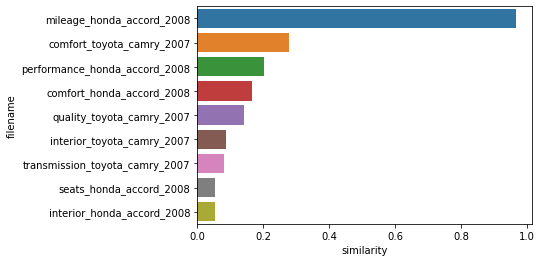

In [89]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# [:, ::-1] 인 이유: 이중 array in this case 
sorted_index = similarity_pair.argsort()[:, ::-1]
sorted_index = sorted_index[:, 1:]
print(sorted_index)

print(hotel_indexes)

# re-sort values by using sorted_index
hotel_sorted_indexes = hotel_indexes[sorted_index.reshape(-1,)]

hotel_1_sim_value = np.sort(similarity_pair.reshape(-1,))[::-1]
hotel_1_sim_value = hotel_1_sim_value[1:]
print(hotel_1_sim_value)

# dataframe 빈 껍데기 만들기
hotel_1_sim_df = pd.DataFrame()
hotel_1_sim_df['filename'] = document_df.iloc[hotel_sorted_indexes]['filename']
hotel_1_sim_df['similarity'] = hotel_1_sim_value

sns.barplot(x='similarity', y='filename', data=hotel_1_sim_df)
plt.show()